In [3]:
import causalpy as cp

from lifetimes import BetaGeoFitter
from lifetimes.plotting import (plot_period_transactions, 
    plot_calibration_purchases_vs_holdout_purchases, 
    plot_cumulative_transactions, 
    plot_incremental_transactions, 
    plot_transaction_rate_heterogeneity,
    plot_dropout_rate_heterogeneity)
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.generate_data import beta_geometric_nbd_model_transactional_data

import numpy as np

import pandas as pd

### Generate Synthetic Data

In [110]:
# BG/NBD model params for generating synthetic data
params = {
    "a": 0.79, 
    "alpha": 4.41, 
    "b": 2.43, 
    "r": 0.24
}

# Number of totals customers, and customers participating in promotion
N = 5000
N_promo = 300


# Create list of customer dataframes and assign IDs
all_customers = [beta_geometric_nbd_model_transactional_data(T=np.random.randint(1,300), observation_period_end="2023-4-1", freq="D", size=1, **params) for i in np.arange(N)]

for i in zip(all_customers, np.arange(N)):
    i[0]['customer_id'] = i[1]

# Generate additional transactions for customers participating in marketing campaign
# (This could be iterated with the previous lines to reduce repetition, but not worth the effort to figure out)
promo_customers = [beta_geometric_nbd_model_transactional_data(T=np.random.randint(1,60), observation_period_end="2023-4-1", freq="D", size=1, **params) for i in np.arange(N_promo)]

for i in zip(promo_customers, np.arange(N_promo)):
    i[0]['customer_id'] = i[1]


# Concat above dataframe lists into a single DF
all_customers.extend(promo_customers)
daily_trans = pd.concat(all_customers)

,date,customer_id,days,t
date,,,,
2022-06-06,2022-06-06,21,1,0
2022-06-07,2022-06-07,14,2,1
2022-06-08,2022-06-08,23,3,2
2022-06-09,2022-06-09,22,4,3
2022-06-10,2022-06-10,18,5,4
...,...,...,...,...
2023-03-28,2023-03-28,87,296,295
2023-03-29,2023-03-29,82,297,296
2023-03-30,2023-03-30,111,298,297


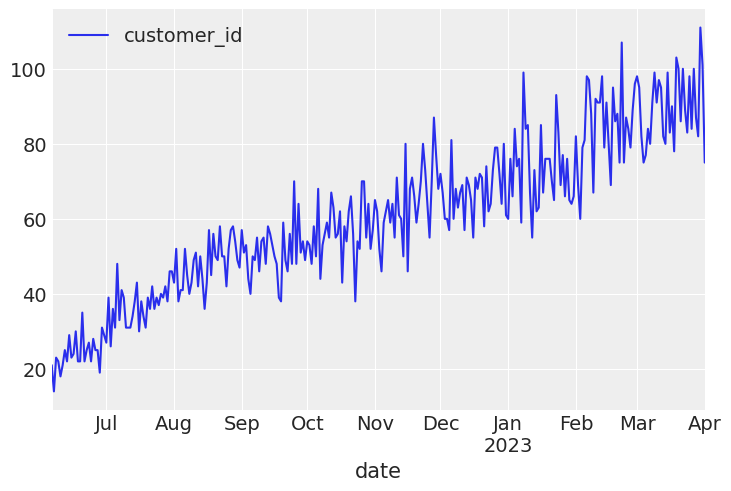

In [111]:
# Aggregate transactions by daily count
daily_df = daily_trans.resample("D", on="date").count()

daily_df.plot()

# Add predictors for CausalPy
daily_df = daily_df.reset_index()
daily_df['days'] = (daily_df['date'] - pd.to_datetime("2022-06-05")).dt.days
daily_df['t'] = daily_df['days'] - 1
daily_df = daily_df.set_index(daily_df['date'])

daily_df

### BG/NBD Modeling

In [24]:
bgf = BetaGeoFitter().fit(data['frequency'], data['recency'], data['T'])

### CausalPy Synthetic Control

In [ ]:
treatment_time = pd.to_datetime("2023-02-01")

result = cp.pymc_experiments.SyntheticControl(
    daily_df,
    treatment_time,
    formula="customer_id ~ 1 + t",
    model=cp.pymc_models.LinearRegression(),
)

In [ ]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df['t'] = df['t'].astype(float)

result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(),
)